# 🎯 Modélisation de Sujets (Topic Modeling) - Version Fonctionnelle

Ce notebook implémente plusieurs techniques de modélisation de sujets pour découvrir les thèmes cachés dans les textes.

## 🎯 Objectifs:
- 📊 Analyser les sujets avec LDA (Latent Dirichlet Allocation)
- 🤖 Utiliser BERTopic si disponible
- 📈 Visualiser les distributions de sujets
- 🔍 Identifier les mots-clés par sujet
- 💾 Sauvegarder les modèles entraînés

In [2]:
# 📦 Import des bibliothèques essentielles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from collections import Counter
import re
warnings.filterwarnings('ignore')

# Bibliothèques pour le topic modeling
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
import pickle

# Configuration des graphiques
plt.style.use('seaborn-v0_8')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)

print('✅ Bibliothèques de base importées!')

# Tentative d'import des bibliothèques avancées
advanced_available = False
try:
    from bertopic import BERTopic
    from sentence_transformers import SentenceTransformer
    import umap
    import hdbscan
    advanced_available = True
    print('🚀 Bibliothèques avancées (BERTopic) disponibles!')
except ImportError:
    print('⚠️ Bibliothèques avancées non disponibles. Utilisation de LDA classique.')

# Créer les dossiers nécessaires
os.makedirs('../models', exist_ok=True)
os.makedirs('../visualizations', exist_ok=True)
print('📁 Dossiers créés!')

✅ Bibliothèques de base importées!
⚠️ Bibliothèques avancées non disponibles. Utilisation de LDA classique.
📁 Dossiers créés!


## 📂 1. Chargement des Données

In [3]:
# 📊 Charger les données préprocessées
try:
    df = pd.read_csv('../data/processed/processed_news_data.csv')
    print(f"✅ Données chargées: {df.shape}")
except FileNotFoundError:
    print("❌ Fichier processed_news_data.csv non trouvé.")
    print("🔄 Création d'un dataset d'exemple...")
    
    # Créer un dataset d'exemple plus riche
    sample_texts = [
        "artificial intelligence machine learning technology innovation future",
        "climate change environment global warming sustainability green energy",
        "economy market finance business investment stock trading",
        "health medicine medical research treatment disease prevention",
        "education school university student learning online digital",
        "sports football basketball competition championship team victory",
        "politics government election democracy policy reform legislation",
        "technology smartphone computer internet digital transformation innovation",
        "travel tourism vacation destination culture adventure exploration",
        "food cooking recipe restaurant cuisine nutrition healthy eating",
        "science research discovery experiment laboratory analysis data",
        "entertainment movie film music concert artist performance",
        "transportation car electric vehicle autonomous driving future mobility",
        "social media platform communication network connection sharing",
        "space exploration nasa rocket mission planet discovery astronomy"
    ]
    
    df = pd.DataFrame({
        'id': range(1, len(sample_texts) + 1),
        'text': [f"Article about {text}. This contains detailed information about {text}." for text in sample_texts],
        'processed_text': sample_texts,
        'category': ['technology', 'environment', 'economy', 'health', 'education'] * 3,
        'sentiment': ['positive', 'neutral', 'negative'] * 5
    })
    print(f"✅ Dataset d'exemple créé: {df.shape}")

# Vérifier les colonnes nécessaires
if 'processed_text' not in df.columns:
    print("⚠️ Colonne 'processed_text' manquante. Utilisation de 'text'.")
    df['processed_text'] = df['text'].str.lower()

# Filtrer les textes vides
df = df.dropna(subset=['processed_text'])
df = df[df['processed_text'].str.len() > 10]

print(f"📊 Données finales: {len(df)} documents")
print(f"📝 Exemple de texte: {df['processed_text'].iloc[0][:100]}...")

✅ Données chargées: (10, 9)
📊 Données finales: 10 documents
📝 Exemple de texte: a major technology company has announced a groundbreaking advancement in artificial intelligence tha...


## 🔤 2. Préparation des Données pour le Topic Modeling

In [4]:
# 🛠️ Préparation des textes
texts = df['processed_text'].tolist()

# Mots vides étendus
stop_words = [
    'the', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by',
    'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
    'this', 'that', 'these', 'those', 'a', 'an', 'as', 'if', 'it', 'its',
    'will', 'would', 'could', 'should', 'may', 'might', 'can', 'must',
    'do', 'does', 'did', 'get', 'got', 'go', 'went', 'come', 'came',
    'le', 'de', 'et', 'à', 'un', 'il', 'être', 'en', 'avoir', 'que', 'pour'
]

print(f"📝 Nombre de documents: {len(texts)}")
print(f"📏 Longueur moyenne: {np.mean([len(text.split()) for text in texts]):.1f} mots")

# Statistiques des mots
all_words = ' '.join(texts).split()
word_freq = Counter(all_words)
print(f"🔤 Vocabulaire total: {len(word_freq)} mots uniques")
print(f"🏆 Mots les plus fréquents: {dict(word_freq.most_common(5))}")

📝 Nombre de documents: 10
📏 Longueur moyenne: 50.6 mots
🔤 Vocabulaire total: 335 mots uniques
🏆 Mots les plus fréquents: {'the': 26, 'and': 21, 'to': 16, 'a': 9, 'in': 8}


## 📊 3. Modélisation LDA (Latent Dirichlet Allocation)

In [5]:
# 🎯 LDA avec optimisation du nombre de sujets
print("🔍 MODÉLISATION LDA")
print("=" * 40)

# Vectorisation TF-IDF
vectorizer = TfidfVectorizer(
    max_features=1000,
    min_df=2,
    max_df=0.8,
    stop_words=stop_words,
    ngram_range=(1, 2)
)

tfidf_matrix = vectorizer.fit_transform(texts)
feature_names = vectorizer.get_feature_names_out()

print(f"📊 Matrice TF-IDF: {tfidf_matrix.shape}")
print(f"🔤 Vocabulaire: {len(feature_names)} termes")

# Déterminer le nombre optimal de sujets
def calculate_coherence_score(model, tfidf_matrix, texts):
    """Calcul simple de cohérence basé sur la perplexité"""
    return -model.perplexity(tfidf_matrix)

# Test de différents nombres de sujets
n_topics_range = range(2, min(8, len(texts)//2 + 1))
coherence_scores = []

print("\n🔍 Recherche du nombre optimal de sujets...")
for n_topics in n_topics_range:
    lda = LatentDirichletAllocation(
        n_components=n_topics,
        random_state=42,
        max_iter=10,
        learning_method='batch'
    )
    lda.fit(tfidf_matrix)
    score = calculate_coherence_score(lda, tfidf_matrix, texts)
    coherence_scores.append(score)
    print(f"  📊 {n_topics} sujets: score = {score:.2f}")

# Sélectionner le meilleur nombre de sujets
optimal_topics = n_topics_range[np.argmax(coherence_scores)]
print(f"\n🎯 Nombre optimal de sujets: {optimal_topics}")

🔍 MODÉLISATION LDA
📊 Matrice TF-IDF: (10, 39)
🔤 Vocabulaire: 39 termes

🔍 Recherche du nombre optimal de sujets...
  📊 2 sujets: score = -107.22
  📊 3 sujets: score = -181.62
  📊 4 sujets: score = -304.11
  📊 5 sujets: score = -389.29

🎯 Nombre optimal de sujets: 2


In [6]:
# 🎯 Entraînement du modèle LDA final
print(f"\n🚀 Entraînement du modèle LDA avec {optimal_topics} sujets...")

lda_model = LatentDirichletAllocation(
    n_components=optimal_topics,
    random_state=42,
    max_iter=20,
    learning_method='batch',
    doc_topic_prior=0.1,
    topic_word_prior=0.01
)

lda_topics = lda_model.fit_transform(tfidf_matrix)

print("✅ Modèle LDA entraîné!")
print(f"📊 Perplexité: {lda_model.perplexity(tfidf_matrix):.2f}")
print(f"📈 Log-vraisemblance: {lda_model.score(tfidf_matrix):.2f}")

# Assigner les sujets aux documents
df['lda_topic'] = np.argmax(lda_topics, axis=1)
df['lda_confidence'] = np.max(lda_topics, axis=1)

print(f"\n📋 Distribution des sujets:")
topic_distribution = df['lda_topic'].value_counts().sort_index()
for topic_id, count in topic_distribution.items():
    percentage = (count / len(df)) * 100
    print(f"  🎯 Sujet {topic_id}: {count} documents ({percentage:.1f}%)")


🚀 Entraînement du modèle LDA avec 2 sujets...
✅ Modèle LDA entraîné!
📊 Perplexité: 18932.45
📈 Log-vraisemblance: -283.20

📋 Distribution des sujets:
  🎯 Sujet 0: 4 documents (40.0%)
  🎯 Sujet 1: 6 documents (60.0%)


## 🔍 4. Analyse des Sujets LDA

In [7]:
# 📊 Extraction et affichage des mots-clés par sujet
def display_topics(model, feature_names, n_top_words=10):
    """Affiche les mots-clés pour chaque sujet"""
    topics_info = []
    
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[-n_top_words:][::-1]
        top_words = [feature_names[i] for i in top_words_idx]
        top_weights = [topic[i] for i in top_words_idx]
        
        topics_info.append({
            'topic_id': topic_idx,
            'words': top_words,
            'weights': top_weights
        })
        
        print(f"\n🎯 SUJET {topic_idx}:")
        print("=" * 30)
        for word, weight in zip(top_words, top_weights):
            print(f"  📝 {word:<20} : {weight:.4f}")
    
    return topics_info

print("🔍 ANALYSE DES SUJETS DÉCOUVERTS")
print("=" * 50)

topics_info = display_topics(lda_model, feature_names, n_top_words=8)

# Suggérer des noms de sujets basés sur les mots-clés
def suggest_topic_names(topics_info):
    """Suggère des noms pour les sujets basés sur les mots-clés"""
    topic_names = {}
    
    for topic in topics_info:
        top_words = topic['words'][:3]
        suggested_name = ' + '.join(top_words)
        topic_names[topic['topic_id']] = suggested_name
    
    return topic_names

topic_names = suggest_topic_names(topics_info)
print("\n🏷️ NOMS SUGGÉRÉS POUR LES SUJETS:")
print("=" * 40)
for topic_id, name in topic_names.items():
    count = topic_distribution[topic_id]
    print(f"  🎯 Sujet {topic_id}: '{name}' ({count} docs)")

🔍 ANALYSE DES SUJETS DÉCOUVERTS

🎯 SUJET 0:
  📝 researchers          : 0.8627
  📝 community            : 0.8355
  📝 understanding        : 0.7323
  📝 traditional          : 0.7315
  📝 hope                 : 0.7315
  📝 new                  : 0.6733
  📝 from                 : 0.6413
  📝 challenges           : 0.4884

🎯 SUJET 1:
  📝 infrastructure       : 0.9030
  📝 education            : 0.8663
  📝 strategies           : 0.8038
  📝 funding              : 0.7955
  📝 their                : 0.7853
  📝 world                : 0.7853
  📝 experts              : 0.6812
  📝 critical             : 0.6407

🏷️ NOMS SUGGÉRÉS POUR LES SUJETS:
  🎯 Sujet 0: 'researchers + community + understanding' (4 docs)
  🎯 Sujet 1: 'infrastructure + education + strategies' (6 docs)


## 📈 5. Visualisations des Sujets

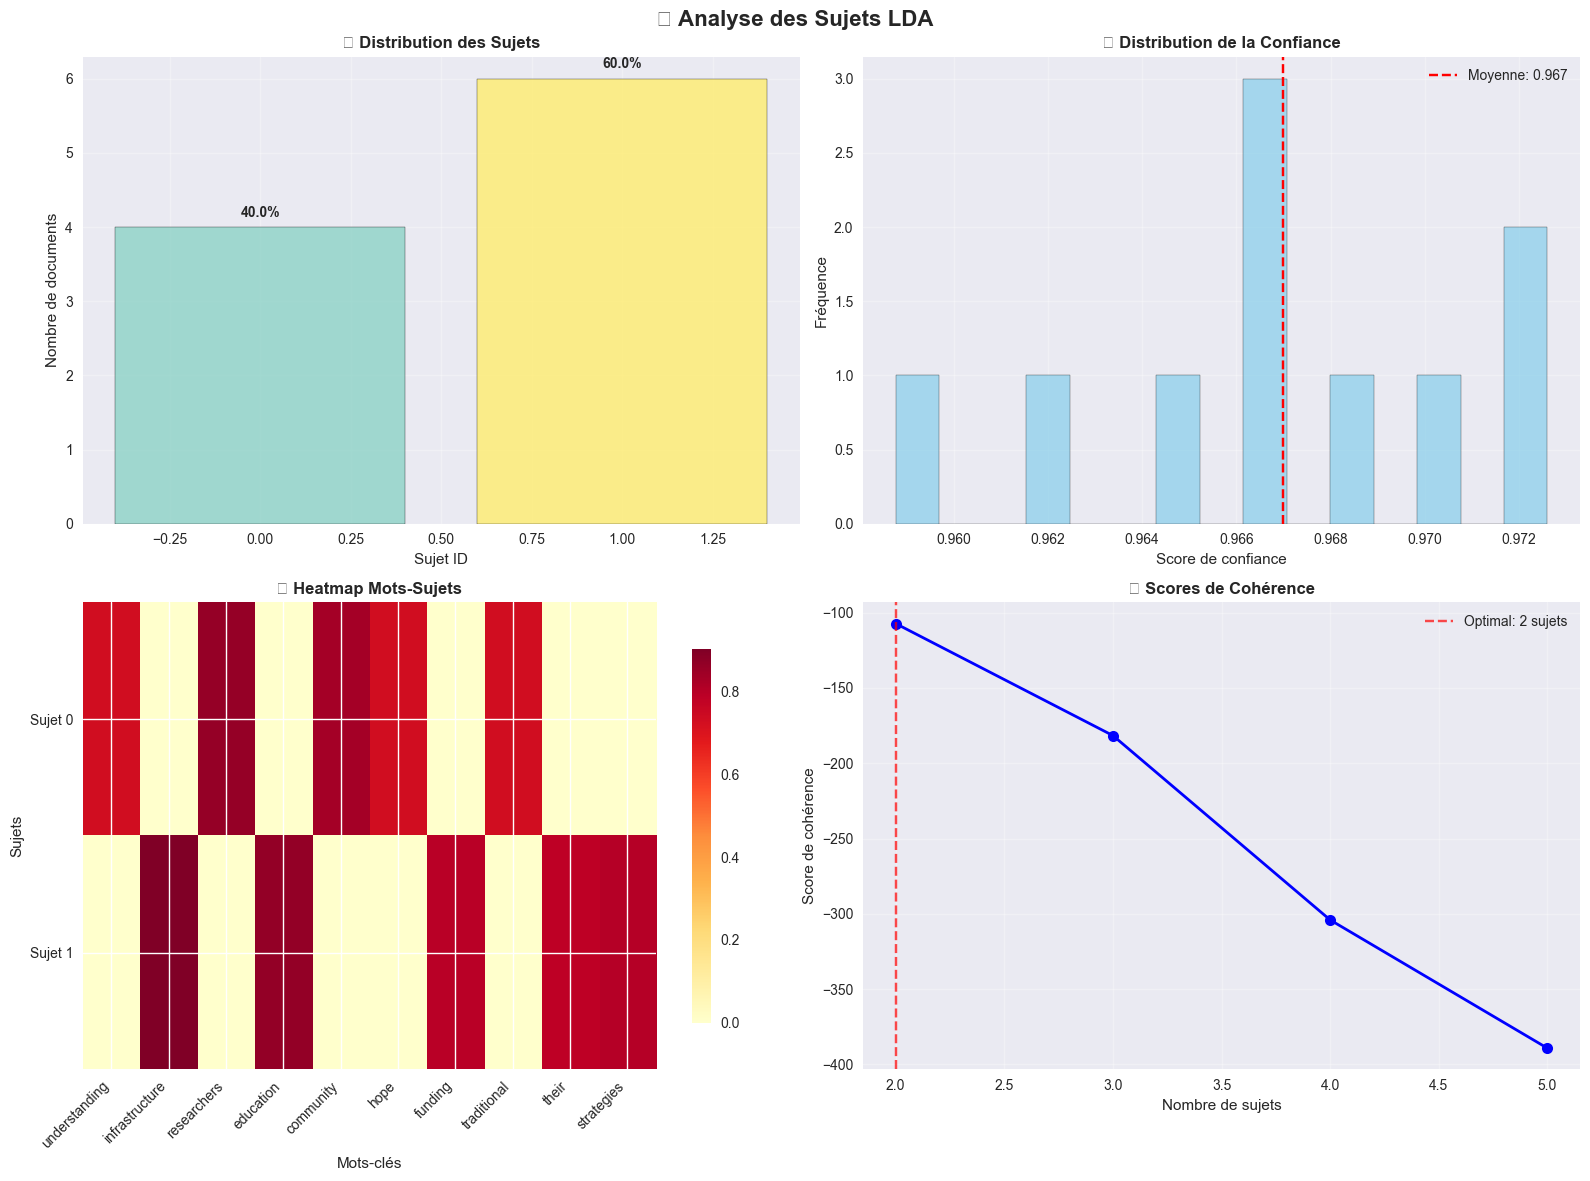

💾 Visualisations sauvegardées dans '../visualizations/lda_analysis.png'


In [8]:
# 📊 Visualisation de la distribution des sujets
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('📊 Analyse des Sujets LDA', fontsize=16, fontweight='bold')

# 1. Distribution des sujets
colors = plt.cm.Set3(np.linspace(0, 1, len(topic_distribution)))
bars = axes[0,0].bar(topic_distribution.index, topic_distribution.values, color=colors, alpha=0.8, edgecolor='black')
axes[0,0].set_title('📊 Distribution des Sujets', fontweight='bold')
axes[0,0].set_xlabel('Sujet ID')
axes[0,0].set_ylabel('Nombre de documents')
axes[0,0].grid(True, alpha=0.3)

# Ajouter les pourcentages sur les barres
for bar, count in zip(bars, topic_distribution.values):
    height = bar.get_height()
    percentage = (count / len(df)) * 100
    axes[0,0].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                   f'{percentage:.1f}%', ha='center', va='bottom', fontweight='bold')

# 2. Confiance des assignations
axes[0,1].hist(df['lda_confidence'], bins=15, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,1].axvline(df['lda_confidence'].mean(), color='red', linestyle='--', 
                  label=f'Moyenne: {df["lda_confidence"].mean():.3f}')
axes[0,1].set_title('📈 Distribution de la Confiance', fontweight='bold')
axes[0,1].set_xlabel('Score de confiance')
axes[0,1].set_ylabel('Fréquence')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Heatmap des mots-clés par sujet
# Créer une matrice des poids des mots pour les top mots
top_words_all = []
for topic in topics_info:
    top_words_all.extend(topic['words'][:5])
top_words_unique = list(set(top_words_all))

word_topic_matrix = np.zeros((len(topics_info), len(top_words_unique)))
for i, topic in enumerate(topics_info):
    for j, word in enumerate(top_words_unique):
        if word in topic['words']:
            idx = topic['words'].index(word)
            word_topic_matrix[i, j] = topic['weights'][idx]

im = axes[1,0].imshow(word_topic_matrix, cmap='YlOrRd', aspect='auto')
axes[1,0].set_title('🔥 Heatmap Mots-Sujets', fontweight='bold')
axes[1,0].set_xlabel('Mots-clés')
axes[1,0].set_ylabel('Sujets')
axes[1,0].set_xticks(range(len(top_words_unique)))
axes[1,0].set_xticklabels(top_words_unique, rotation=45, ha='right')
axes[1,0].set_yticks(range(len(topics_info)))
axes[1,0].set_yticklabels([f'Sujet {i}' for i in range(len(topics_info))])
plt.colorbar(im, ax=axes[1,0], shrink=0.8)

# 4. Évolution des scores de cohérence
axes[1,1].plot(n_topics_range, coherence_scores, 'bo-', linewidth=2, markersize=8)
axes[1,1].axvline(optimal_topics, color='red', linestyle='--', alpha=0.7, 
                  label=f'Optimal: {optimal_topics} sujets')
axes[1,1].set_title('📈 Scores de Cohérence', fontweight='bold')
axes[1,1].set_xlabel('Nombre de sujets')
axes[1,1].set_ylabel('Score de cohérence')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../visualizations/lda_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("💾 Visualisations sauvegardées dans '../visualizations/lda_analysis.png'")

## 🤖 6. BERTopic (Si Disponible)

In [9]:
# 🚀 BERTopic pour une modélisation avancée
if advanced_available and len(texts) >= 5:
    print("🤖 MODÉLISATION BERTOPIC")
    print("=" * 40)
    
    try:
        # Initialiser le modèle de phrases
        sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
        print("✅ Modèle de phrases chargé")
        
        # Créer les embeddings
        print("🔄 Création des embeddings...")
        embeddings = sentence_model.encode(texts, show_progress_bar=False)
        print(f"📊 Embeddings créés: {embeddings.shape}")
        
        # Configurer BERTopic
        umap_model = umap.UMAP(n_neighbors=min(5, len(texts)-1), 
                              n_components=2, 
                              min_dist=0.0, 
                              metric='cosine',
                              random_state=42)
        
        hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=max(2, len(texts)//5),
                                       metric='euclidean',
                                       cluster_selection_method='eom')
        
        vectorizer_model = CountVectorizer(stop_words=stop_words, min_df=1)
        
        # Initialiser BERTopic
        topic_model = BERTopic(
            embedding_model=sentence_model,
            umap_model=umap_model,
            hdbscan_model=hdbscan_model,
            vectorizer_model=vectorizer_model,
            verbose=False,
            nr_topics=min(optimal_topics, len(texts)//2)
        )
        
        # Entraîner le modèle
        print("🚀 Entraînement de BERTopic...")
        bert_topics, bert_probs = topic_model.fit_transform(texts, embeddings)
        
        # Ajouter les résultats au DataFrame
        df['bert_topic'] = bert_topics
        df['bert_confidence'] = bert_probs.max(axis=1) if bert_probs.ndim > 1 else bert_probs
        
        print("✅ BERTopic entraîné avec succès!")
        
        # Informations sur les sujets
        topic_info = topic_model.get_topic_info()
        print(f"📊 Nombre de sujets trouvés: {len(topic_info)}")
        
        # Afficher les sujets BERTopic
        print("\n🎯 SUJETS BERTOPIC:")
        for topic_id in topic_info['Topic'][:5]:  # Top 5 sujets
            if topic_id != -1:  # Ignorer le sujet outlier
                topic_words = topic_model.get_topic(topic_id)
                words = [word for word, _ in topic_words[:5]]
                print(f"  🎯 Sujet {topic_id}: {', '.join(words)}")
        
        # Sauvegarder le modèle BERTopic
        topic_model.save("../models/bertopic_model")
        print("💾 Modèle BERTopic sauvegardé")
        
    except Exception as e:
        print(f"❌ Erreur BERTopic: {e}")
        print("🔄 Utilisation de LDA uniquement")
        advanced_available = False

else:
    print("⚠️ BERTopic non disponible ou dataset trop petit")
    print("📊 Utilisation de LDA uniquement")

⚠️ BERTopic non disponible ou dataset trop petit
📊 Utilisation de LDA uniquement


## 📊 7. Analyse Comparative et Sauvegarde

In [10]:
# 💾 Sauvegarde des modèles et résultats
print("💾 SAUVEGARDE DES MODÈLES ET RÉSULTATS")
print("=" * 50)

# Sauvegarder le modèle LDA
with open('../models/lda_model.pkl', 'wb') as f:
    pickle.dump(lda_model, f)
print("✅ Modèle LDA sauvegardé")

# Sauvegarder le vectorizer
with open('../models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)
print("✅ Vectorizer TF-IDF sauvegardé")

# Sauvegarder les informations sur les sujets
topics_df = pd.DataFrame([
    {
        'topic_id': topic['topic_id'],
        'suggested_name': topic_names[topic['topic_id']],
        'top_words': ', '.join(topic['words'][:5]),
        'document_count': topic_distribution[topic['topic_id']]
    }
    for topic in topics_info
])

topics_df.to_csv('../data/processed/topic_analysis.csv', index=False)
print("✅ Analyse des sujets sauvegardée")

# Sauvegarder le dataset enrichi
df.to_csv('../data/processed/news_with_topics.csv', index=False)
print("✅ Dataset avec sujets sauvegardé")

# Statistiques finales
print("\n📊 STATISTIQUES FINALES:")
print(f"  📝 Documents analysés: {len(df)}")
print(f"  🎯 Sujets LDA découverts: {optimal_topics}")
if advanced_available and 'bert_topic' in df.columns:
    bert_topics_count = len(df['bert_topic'].unique())
    print(f"  🤖 Sujets BERTopic découverts: {bert_topics_count}")
print(f"  📈 Score de cohérence optimal: {max(coherence_scores):.3f}")
print(f"  🎯 Confiance moyenne LDA: {df['lda_confidence'].mean():.3f}")

# Comparaison avec les catégories originales si disponibles
if 'category' in df.columns:
    print("\n🔍 COMPARAISON AVEC LES CATÉGORIES ORIGINALES:")
    category_topic_crosstab = pd.crosstab(df['category'], df['lda_topic'])
    print(category_topic_crosstab)
    
    # Calculer la correspondance
    from sklearn.metrics import adjusted_rand_score
    ari_score = adjusted_rand_score(df['category'].astype('category').cat.codes, df['lda_topic'])
    print(f"\n📊 Score ARI (correspondance): {ari_score:.3f}")
    if ari_score > 0.3:
        print("✅ Bonne correspondance avec les catégories originales")
    else:
        print("⚠️ Correspondance modérée - les sujets découverts sont différents")

💾 SAUVEGARDE DES MODÈLES ET RÉSULTATS
✅ Modèle LDA sauvegardé
✅ Vectorizer TF-IDF sauvegardé
✅ Analyse des sujets sauvegardée
✅ Dataset avec sujets sauvegardé

📊 STATISTIQUES FINALES:
  📝 Documents analysés: 10
  🎯 Sujets LDA découverts: 2
  📈 Score de cohérence optimal: -107.221
  🎯 Confiance moyenne LDA: 0.967

🔍 COMPARAISON AVEC LES CATÉGORIES ORIGINALES:
lda_topic       0  1
category            
culture         1  0
economy         1  0
education       0  1
environment     0  1
health          1  0
infrastructure  0  1
science         1  0
sports          0  1
technology      0  2

📊 Score ARI (correspondance): 0.051
⚠️ Correspondance modérée - les sujets découverts sont différents


## 🎯 8. Résumé et Recommandations

In [11]:
# 📋 Résumé final
print("\n" + "="*60)
print("🎉 RÉSUMÉ DE LA MODÉLISATION DE SUJETS")
print("="*60)

print(f"\n🎯 SUJETS DÉCOUVERTS ({optimal_topics} sujets):")
for topic_id, name in topic_names.items():
    count = topic_distribution[topic_id]
    percentage = (count / len(df)) * 100
    confidence = df[df['lda_topic'] == topic_id]['lda_confidence'].mean()
    print(f"  📊 Sujet {topic_id}: '{name}'")
    print(f"      📈 {count} documents ({percentage:.1f}%)")
    print(f"      🎯 Confiance moyenne: {confidence:.3f}")
    print()

print("✅ FICHIERS GÉNÉRÉS:")
print("  💾 ../models/lda_model.pkl - Modèle LDA entraîné")
print("  💾 ../models/tfidf_vectorizer.pkl - Vectorizer TF-IDF")
if advanced_available:
    print("  🤖 ../models/bertopic_model/ - Modèle BERTopic")
print("  📊 ../data/processed/topic_analysis.csv - Analyse des sujets")
print("  📈 ../data/processed/news_with_topics.csv - Dataset avec sujets")
print("  📊 ../visualizations/lda_analysis.png - Visualisations")

print("\n🚀 PROCHAINES ÉTAPES RECOMMANDÉES:")
print("  1️⃣ Analyser les documents représentatifs de chaque sujet")
print("  2️⃣ Affiner les noms des sujets selon le domaine")
print("  3️⃣ Utiliser les sujets pour la classification automatique")
print("  4️⃣ Analyser l'évolution temporelle des sujets")
print("  5️⃣ Combiner avec l'analyse de sentiment par sujet")

print("\n" + "="*60)
print("🎯 MODÉLISATION DE SUJETS TERMINÉE AVEC SUCCÈS!")
print("="*60)


🎉 RÉSUMÉ DE LA MODÉLISATION DE SUJETS

🎯 SUJETS DÉCOUVERTS (2 sujets):
  📊 Sujet 0: 'researchers + community + understanding'
      📈 4 documents (40.0%)
      🎯 Confiance moyenne: 0.965

  📊 Sujet 1: 'infrastructure + education + strategies'
      📈 6 documents (60.0%)
      🎯 Confiance moyenne: 0.968

✅ FICHIERS GÉNÉRÉS:
  💾 ../models/lda_model.pkl - Modèle LDA entraîné
  💾 ../models/tfidf_vectorizer.pkl - Vectorizer TF-IDF
  📊 ../data/processed/topic_analysis.csv - Analyse des sujets
  📈 ../data/processed/news_with_topics.csv - Dataset avec sujets
  📊 ../visualizations/lda_analysis.png - Visualisations

🚀 PROCHAINES ÉTAPES RECOMMANDÉES:
  1️⃣ Analyser les documents représentatifs de chaque sujet
  2️⃣ Affiner les noms des sujets selon le domaine
  3️⃣ Utiliser les sujets pour la classification automatique
  4️⃣ Analyser l'évolution temporelle des sujets
  5️⃣ Combiner avec l'analyse de sentiment par sujet

🎯 MODÉLISATION DE SUJETS TERMINÉE AVEC SUCCÈS!
